# Pykrige Toy Well Data

### Loading Tools and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging
from pykrige.ok3d import OrdinaryKriging3D
from pykrige.uk3d import UniversalKriging3D
from pykrige.rk import Krige
from gstools import SRF, Gaussian, Spherical, Exponential, krige
import pprint
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

df_corr = pd.read_csv('toy_data/toy_synth_corr_wells.csv')
df_nocorr = pd.read_csv('toy_data/toy_synth_nocorr_wells.csv')

## Spatially Correlated Data

### Inspect Data

In [2]:
df = df_corr.copy()
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   API_WellNo             750 non-null    int64  
 1   Cnty                   750 non-null    object 
 2   Well_Type              750 non-null    object 
 3   Well_Status            750 non-null    object 
 4   Producing_name         750 non-null    object 
 5   Producing_formation    750 non-null    object 
 6   Proposed_depth         750 non-null    int64  
 7   Surface_Longitude      750 non-null    float64
 8   Surface_Latitude       750 non-null    float64
 9   Bottom_hole_longitude  750 non-null    float64
 10  Bottom_hole_latitude   750 non-null    float64
 11  True_vertical_depth    750 non-null    int64  
 12  Measured_depth         750 non-null    int64  
 13  GasProd                750 non-null    float64
 14  OilProd                750 non-null    float64
 15  WaterP

API_WellNo     Cnty Well_Type Well_Status Producing_name  \
0  24012181361672  CountyC       Gas      Active         Field2   
1  89418511661948  CountyA       Gas      Active         Field3   
2  30087839072036  CountyA       Gas      Active         Field1   
3  28316077141053  CountyA       Oil    Inactive         Field1   
4  59875564545465  CountyB       Gas    Inactive         Field3   

  Producing_formation  Proposed_depth  Surface_Longitude  Surface_Latitude  \
0          Formation2            4352             -96.25             31.17   
1          Formation2            4478             -90.49             39.40   
2          Formation1            4927             -92.68             36.28   
3          Formation2            4684             -94.01             33.35   
4          Formation1            3841             -98.44             31.39   

   Bottom_hole_longitude  Bottom_hole_latitude  True_vertical_depth  \
0                 -96.25                 31.17                 2417   
1                 -90.49                 39.40                 2681   
2                 -92.68                 36.28                 1113   
3                 -94.01                 33.35                 1927   
4                 -98.44                 31.39                 2016   

   Measured_depth   GasProd  OilProd  WaterProd  Year  
0            3280 -3,937.70 1,322.54        304  2005  
1            4749 -3,410.10 1,540.74         27  2010  
2            3538 -3,703.48 1,422.88        287  2010  
3            2016 -3,782.94 1,346.25        354  2005  
4            1443 -3,870.86 1,239.79        966  2010

### Data Overview Plot

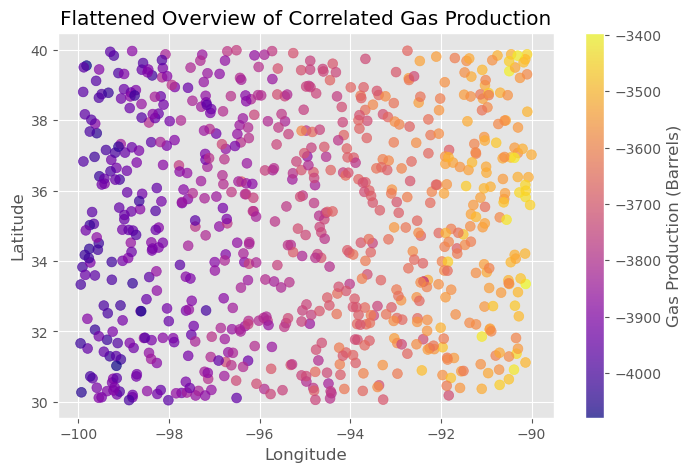

In [3]:
fig, ax = plt.subplots(1, figsize=(8,5))
corr_plot = ax.scatter(np.array(df['Surface_Longitude']), np.array(df['Surface_Latitude']), 
                       s=50, c=np.array(df['GasProd']).flatten(), cmap='plasma', alpha=0.7)
plt.colorbar(corr_plot).set_label('Gas Production (Barrels)')
plt.title('Flattened Overview of Correlated Gas Production')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

### Coordinates, Values, and Grid Setup

In [4]:
train, test = train_test_split(df, test_size=0.25, random_state=42)

xy_gasprod_train = np.array(train[['Surface_Longitude','Surface_Latitude']].values)
v_gasprod_train = np.array(train['GasProd'].values)
x_train = xy_gasprod_train[:,0]
y_train = xy_gasprod_train[:,1]
h_train = np.array(train['True_vertical_depth'].values)

xy_gasprod_test = np.array(test[['Surface_Longitude','Surface_Latitude']].values)
v_gasprod_test = np.array(test['GasProd'].values)
x_test = xy_gasprod_test[:,0]
y_test = xy_gasprod_test[:,1]
h_test = np.array(test['True_vertical_depth'].values)

gridx_train = np.linspace(x_train.min(), x_train.max(), 100)
gridy_train = np.linspace(y_train.min(), y_train.max(), 100)
gridh_train = np.linspace(h_train.min(), h_train.max(), 100)

gridx_test = np.linspace(x_test.min(), x_test.max(), 100)
gridy_test = np.linspace(y_test.min(), y_test.max(), 100)
gridh_test = np.linspace(h_test.min(), h_test.max(), 100)

actual = v_gasprod_test

### Basic Model - Kriging

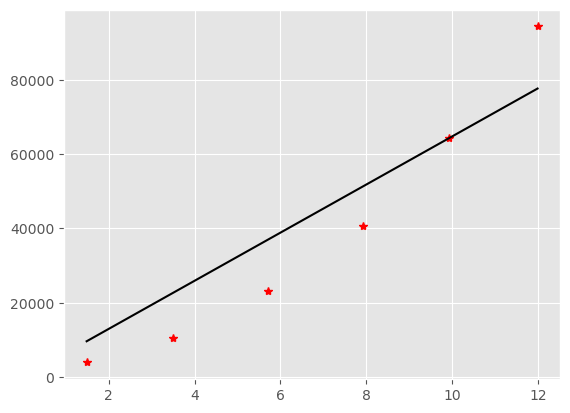


------------

RMSE: 60.523
MAE: 49.772
R2: 0.862

------------



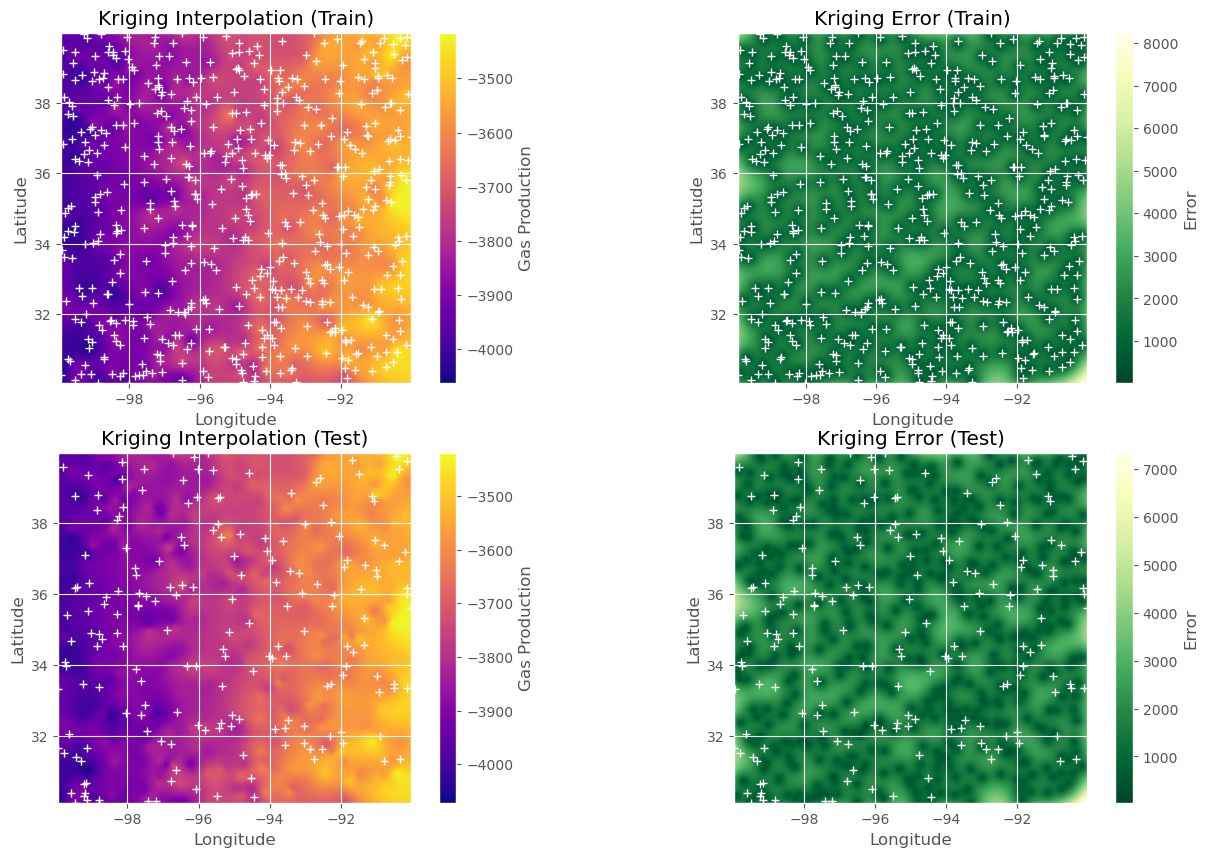

In [5]:
ok = OrdinaryKriging(
    x_train,
    y_train,
    v_gasprod_train,
    variogram_model='linear',
    verbose=False,
    enable_plotting=True )

z_train, s2_train = ok.execute("grid", gridx_train, gridy_train)
z_test, s2_test = ok.execute('grid', gridx_test, gridy_test)
pred, error = ok.execute('points', x_test, y_test)

rmse = np.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

print('\n------------\n')
print("RMSE:", round(rmse,3))
print("MAE:", round(mae,3))
print("R2:", round(r2,3))
print('\n------------\n')

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(16,10))

im1 = ax1.imshow(z_train, cmap='plasma', interpolation='bilinear', vmin=z_train.min(), vmax=z_train.max(),
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax1.set_title('Kriging Interpolation (Train)')
ax1.plot(x_train, y_train, 'w+')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.colorbar(im1, ax=ax1, label='Gas Production')

im2 = ax2.imshow(s2_train, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax2.set_title('Kriging Error (Train)')
ax2.plot(x_train, y_train, 'w+')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(im2, ax=ax2, label='Error')

im3 = ax3.imshow(z_test, cmap='plasma', interpolation='bilinear', vmin=z_test.min(), vmax=z_test.max(),
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax3.set_title('Kriging Interpolation (Test)')
ax3.plot(x_test, y_test, 'w+')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
plt.colorbar(im3, ax=ax3, label='Gas Production')

im4 = ax4.imshow(s2_test, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax4.set_title('Kriging Error (Test)')
ax4.plot(x_test, y_test, 'w+')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
plt.colorbar(im4, ax=ax4, label='Error')

plt.show()
plt.close()

### Kriging Hyperparameter Tuning

Fitting 5 folds for each of 4 candidates, totalling 20 fits
best_RMSE = -53.912
best_params =  {'method': 'ordinary', 'variogram_model': 'power'}

------------

RMSE: 54.764
MAE: 44.285
R2: 0.887

------------



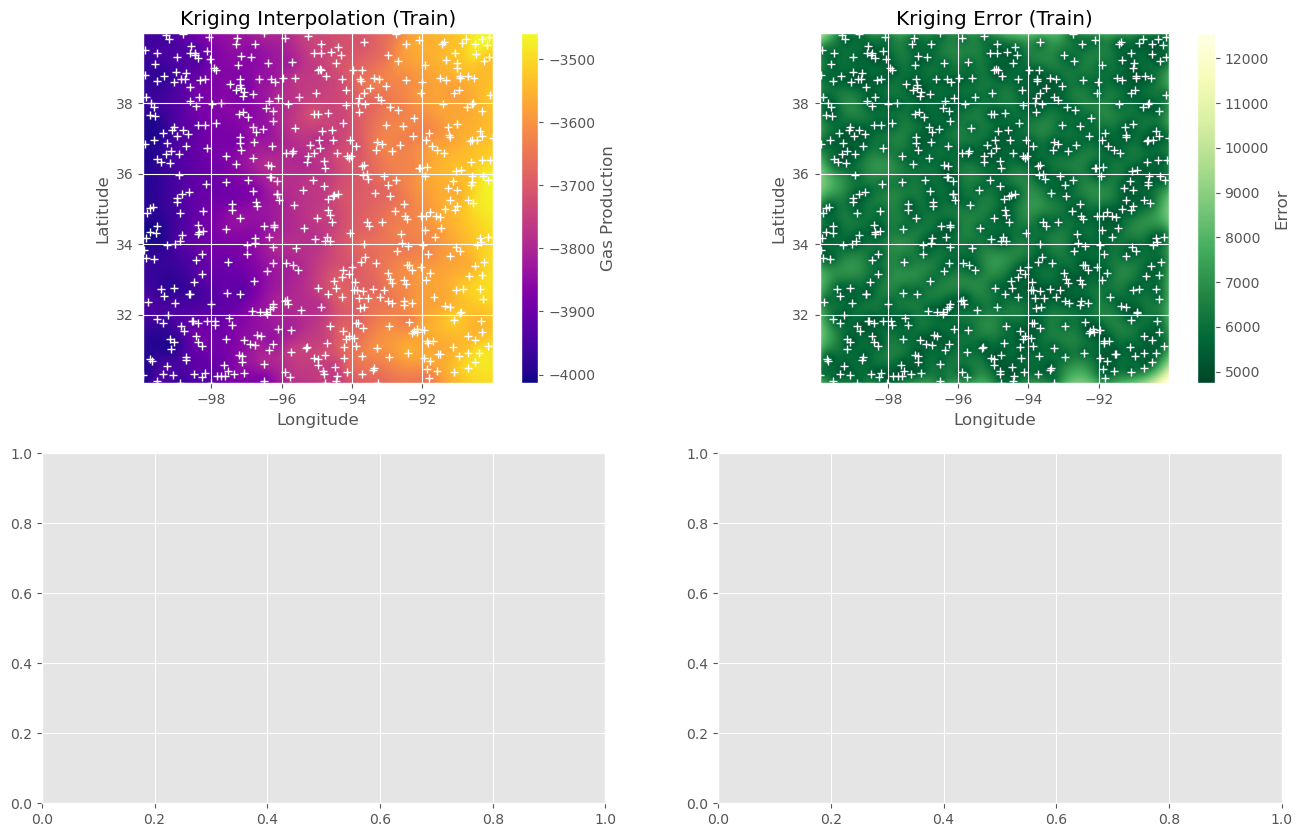

In [6]:
param_grid = {
    'method': ['ordinary'], # 'universal'],
    'variogram_model': ['linear','power','gaussian','spherical']
    # 'nlags': [4,6,8],
    # 'weight': [True,False]
}

estimator = GridSearchCV (
    Krige(), 
    param_grid, 
    cv=5, 
    scoring='neg_root_mean_squared_error',
    verbose=True, 
    return_train_score=True )

estimator.fit(X=xy_gasprod_train, y=v_gasprod_train)

if estimator.best_score_:
    print("best_RMSE = {:.3f}".format(estimator.best_score_))
    print("best_params = ", estimator.best_params_)

best_model = estimator.best_estimator_
best_model = best_model.model

z_train, s2_train = best_model.execute('grid', gridx_train, gridy_train)
z_test, s2_test = best_model.execute('grid', gridx_test, gridy_test)
pred, error = best_model.execute('points', x_test, y_test)

rmse = np.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

print('\n------------\n')
print("RMSE:", round(rmse,3))
print("MAE:", round(mae,3))
print("R2:", round(r2,3))
print('\n------------\n')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

im1 = ax1.imshow(z_train, cmap='plasma', interpolation='bilinear', vmin=z_train.min(), vmax=z_train.max(),
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax1.set_title('Kriging Interpolation (Train)')
ax1.plot(x_train, y_train, 'w+')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.colorbar(im1, ax=ax1, label='Gas Production')

im2 = ax2.imshow(s2_train, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax2.set_title('Kriging Error (Train)')
ax2.plot(x_train, y_train, 'w+')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(im2, ax=ax2, label='Error')

\

plt.show()
plt.close()

### Stationarity vs Isotropy vs Anisotropy

#### Stationarity
Stationarity assumes that statistical properties like mean and variance are constant across the spatial domain. OrdinaryKriging assumes stationarity.

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 48157.61670105548
Full Sill: 48157.6167010556
Range: 11.98821959610347
Nugget: 1.2408813716124613e-10 



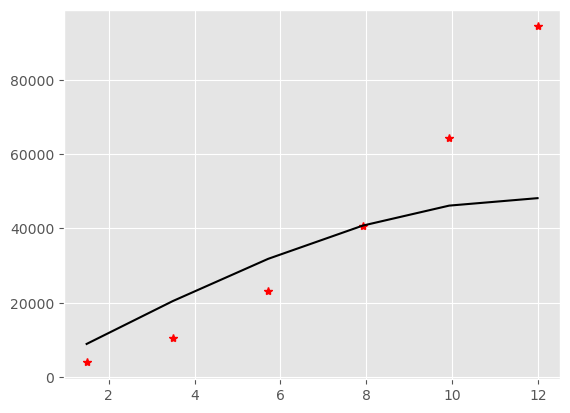

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Executing Ordinary Kriging...

Executing Ordinary Kriging...


------------

RMSE: 60.568
MAE: 49.796
R2: 0.862

------------



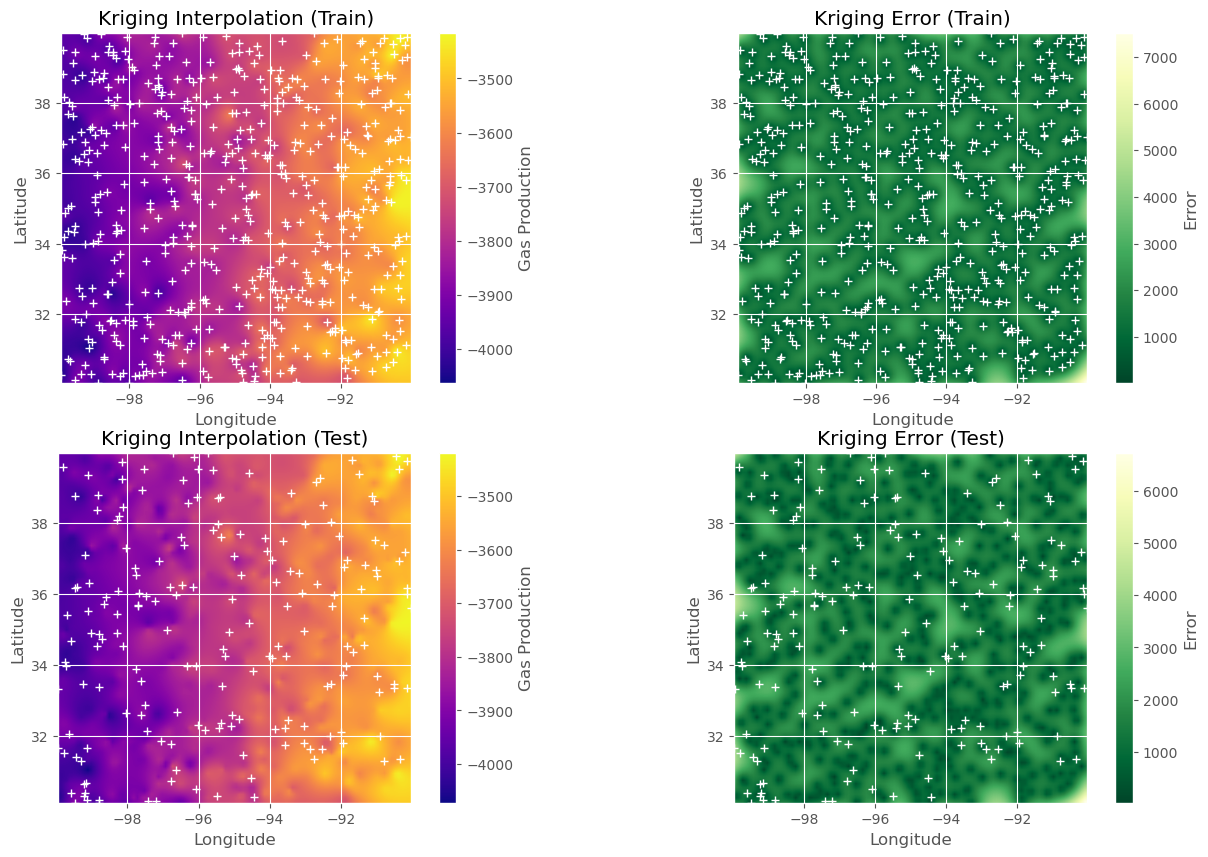

In [7]:
ok = OrdinaryKriging(
    x_train, y_train, v_gasprod_train,
    variogram_model='spherical',
    verbose=True,
    enable_plotting=True )

z_train, s2_train = ok.execute('grid', gridx_train, gridy_train)
z_test, s2_test = ok.execute('grid', gridx_test, gridy_test)
pred, error = ok.execute('points', x_test, y_test)

rmse = np.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

print('\n------------\n')
print("RMSE:", round(rmse,3))
print("MAE:", round(mae,3))
print("R2:", round(r2,3))
print('\n------------\n')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

im1 = ax1.imshow(z_train, cmap='plasma', interpolation='bilinear', vmin=z_train.min(), vmax=z_train.max(),
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax1.set_title('Kriging Interpolation (Train)')
ax1.plot(x_train, y_train, 'w+')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.colorbar(im1, ax=ax1, label='Gas Production')

im2 = ax2.imshow(s2_train, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax2.set_title('Kriging Error (Train)')
ax2.plot(x_train, y_train, 'w+')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(im2, ax=ax2, label='Error')

im3 = ax3.imshow(z_test, cmap='plasma', interpolation='bilinear', vmin=z_test.min(), vmax=z_test.max(),
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax3.set_title('Kriging Interpolation (Test)')
ax3.plot(x_test, y_test, 'w+')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
plt.colorbar(im3, ax=ax3, label='Gas Production')

im4 = ax4.imshow(s2_test, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax4.set_title('Kriging Error (Test)')
ax4.plot(x_test, y_test, 'w+')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
plt.colorbar(im4, ax=ax4, label='Error')

plt.show()
plt.close()

#### Isotropy
Isotropy assumes that the spatial correlation is the same in all directions.

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 0.5
Full Sill: 0.5
Range: 10
Nugget: 0 



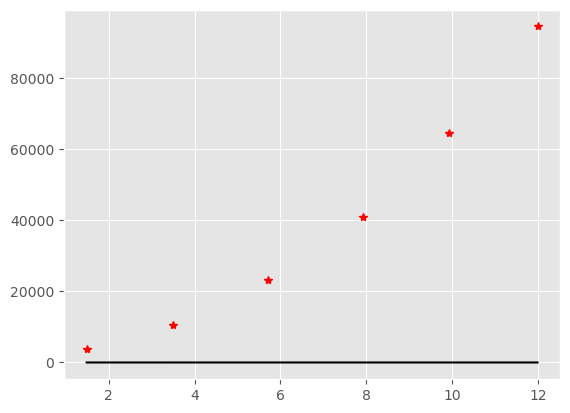

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Executing Ordinary Kriging...

Executing Ordinary Kriging...


------------

RMSE: 60.572
MAE: 49.772
R2: 0.862

------------



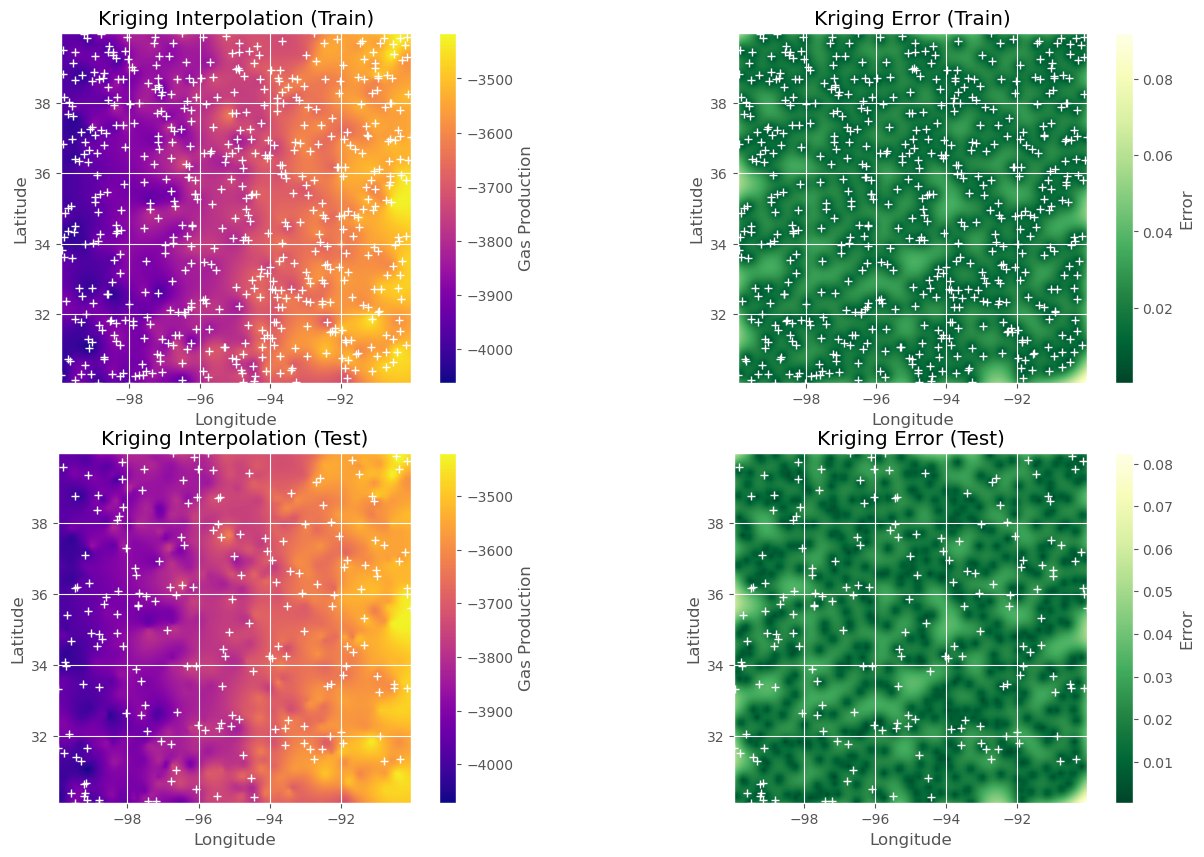

In [8]:
variogram_parameters = {
    'range': 10,
    'nugget': 0,
    'sill': 0.5 }

ok = OrdinaryKriging(
    x_train, y_train, v_gasprod_train,
    variogram_model='spherical',
    variogram_parameters=variogram_parameters,
    verbose=True,
    enable_plotting=True )

z_train, s2_train = ok.execute('grid', gridx_train, gridy_train)
z_test, s2_test = ok.execute('grid', gridx_test, gridy_test)
pred, error = ok.execute('points', x_test, y_test)

rmse = np.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

print('\n------------\n')
print("RMSE:", round(rmse,3))
print("MAE:", round(mae,3))
print("R2:", round(r2,3))
print('\n------------\n')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

im1 = ax1.imshow(z_train, cmap='plasma', interpolation='bilinear', vmin=z_train.min(), vmax=z_train.max(),
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax1.set_title('Kriging Interpolation (Train)')
ax1.plot(x_train, y_train, 'w+')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.colorbar(im1, ax=ax1, label='Gas Production')

im2 = ax2.imshow(s2_train, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax2.set_title('Kriging Error (Train)')
ax2.plot(x_train, y_train, 'w+')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(im2, ax=ax2, label='Error')

im3 = ax3.imshow(z_test, cmap='plasma', interpolation='bilinear', vmin=z_test.min(), vmax=z_test.max(),
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax3.set_title('Kriging Interpolation (Test)')
ax3.plot(x_test, y_test, 'w+')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
plt.colorbar(im3, ax=ax3, label='Gas Production')

im4 = ax4.imshow(s2_test, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax4.set_title('Kriging Error (Test)')
ax4.plot(x_test, y_test, 'w+')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
plt.colorbar(im4, ax=ax4, label='Error')

plt.show()
plt.close()

#### Anisotropy
Anisotropy assumes that the spatial correlation varies with direction.

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 52956.0750757549
Full Sill: 52956.0750757549
Range: 22.709389982254102
Nugget: 6.439146794367796e-15 



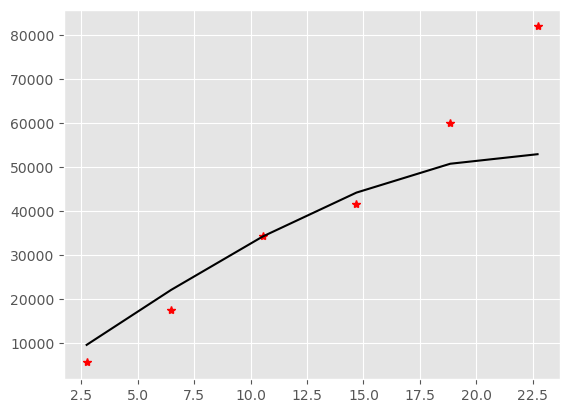

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Executing Ordinary Kriging...

Executing Ordinary Kriging...


------------

RMSE: 61.111
MAE: 49.879
R2: 0.86

------------



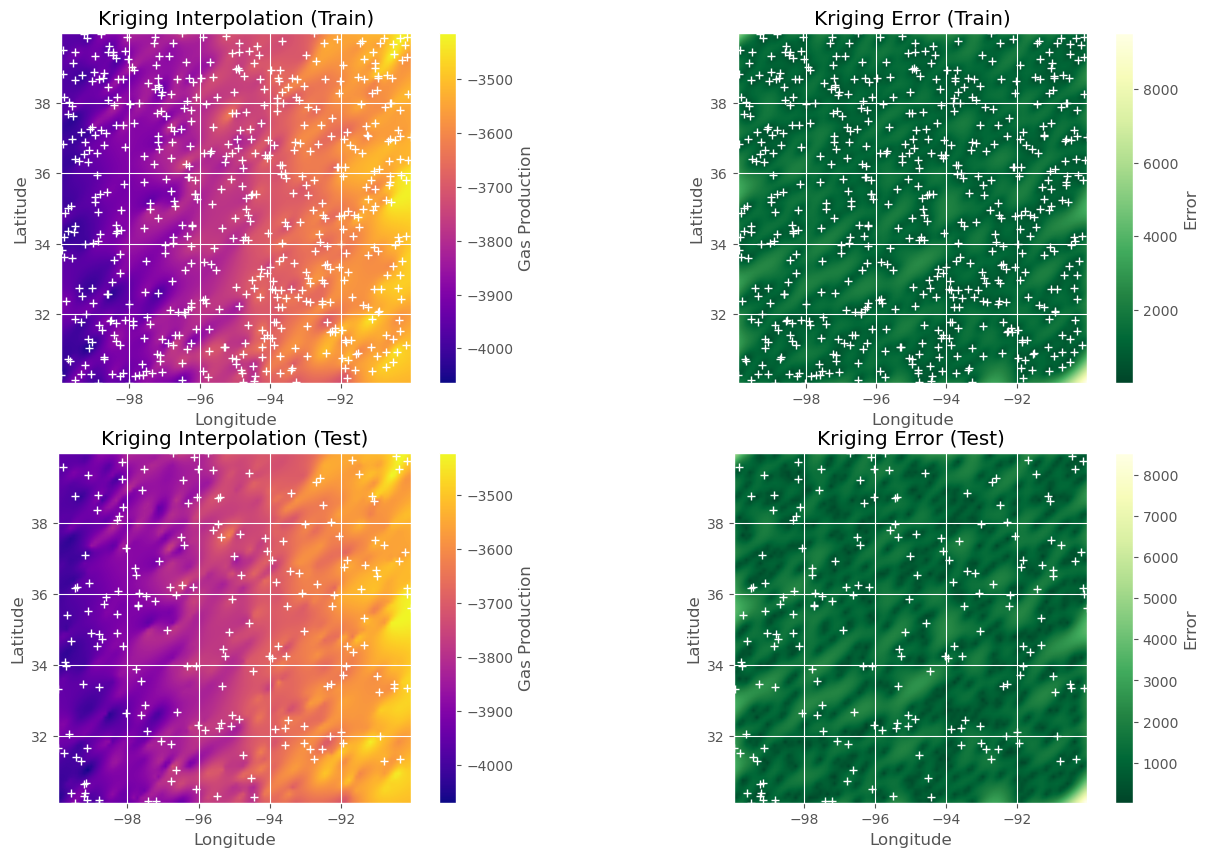

In [9]:
anisotropy_scaling = 2.0
anisotropy_angle = 45.0

ok = OrdinaryKriging(
    x_train, y_train, v_gasprod_train,
    variogram_model='spherical',
    anisotropy_scaling=anisotropy_scaling,
    anisotropy_angle=anisotropy_angle,
    verbose=True,
    enable_plotting=True )

z_train, s2_train = ok.execute('grid', gridx_train, gridy_train)
z_test, s2_test = ok.execute('grid', gridx_test, gridy_test)
pred, error = ok.execute('points', x_test, y_test)

rmse = np.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

print('\n------------\n')
print("RMSE:", round(rmse,3))
print("MAE:", round(mae,3))
print("R2:", round(r2,3))
print('\n------------\n')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

im1 = ax1.imshow(z_train, cmap='plasma', interpolation='bilinear', vmin=z_train.min(), vmax=z_train.max(),
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax1.set_title('Kriging Interpolation (Train)')
ax1.plot(x_train, y_train, 'w+')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.colorbar(im1, ax=ax1, label='Gas Production')

im2 = ax2.imshow(s2_train, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax2.set_title('Kriging Error (Train)')
ax2.plot(x_train, y_train, 'w+')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(im2, ax=ax2, label='Error')

im3 = ax3.imshow(z_test, cmap='plasma', interpolation='bilinear', vmin=z_test.min(), vmax=z_test.max(),
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax3.set_title('Kriging Interpolation (Test)')
ax3.plot(x_test, y_test, 'w+')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
plt.colorbar(im3, ax=ax3, label='Gas Production')

im4 = ax4.imshow(s2_test, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax4.set_title('Kriging Error (Test)')
ax4.plot(x_test, y_test, 'w+')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
plt.colorbar(im4, ax=ax4, label='Error')

plt.show()
plt.close()

### Krige Detrend

#### Method: Subtracting Actual Values from Trend Values (found from Linear Regression)

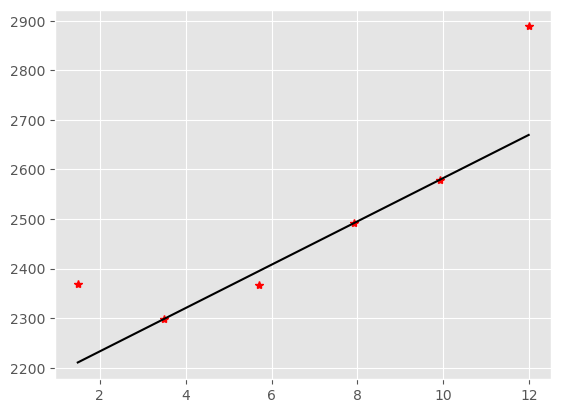


------------

RMSE: 51.239
MAE: 40.741
R2: 0.901

------------



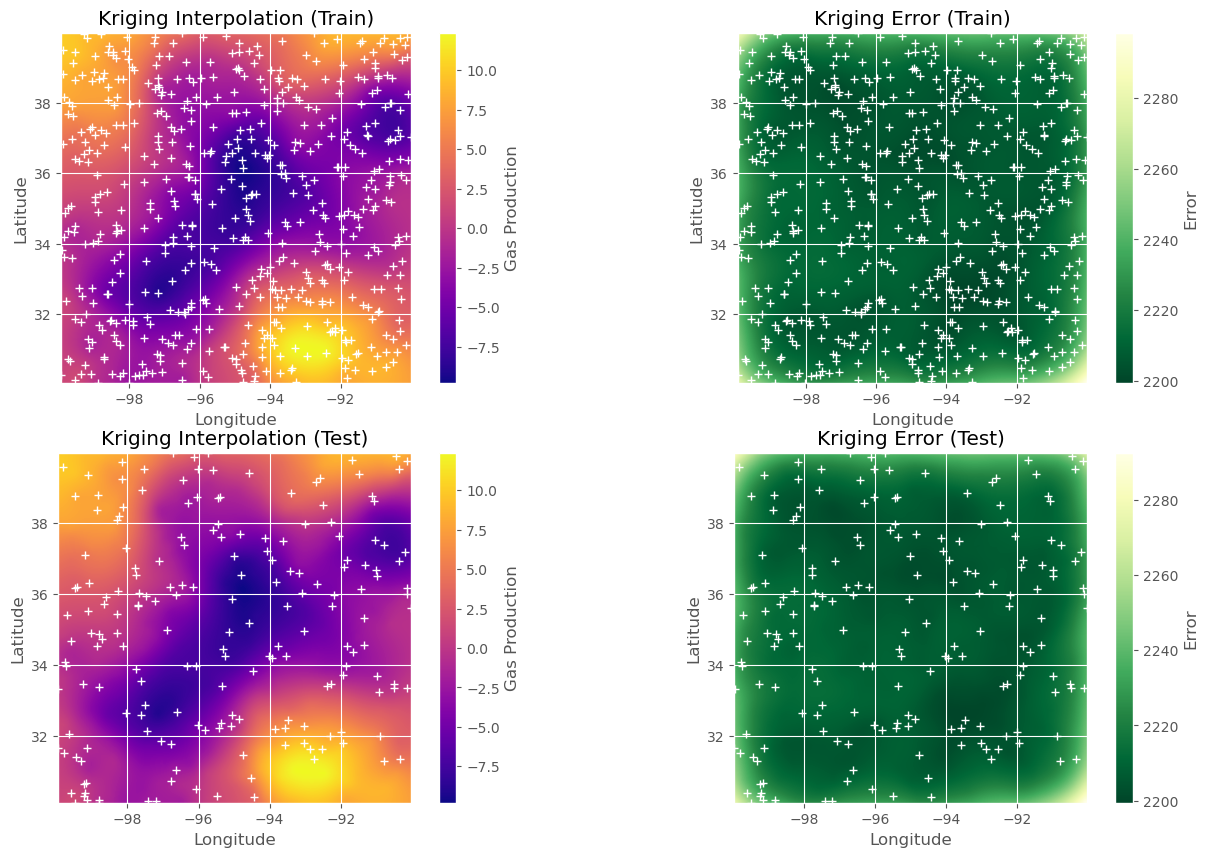

In [10]:
reg = LinearRegression().fit(xy_gasprod_train, v_gasprod_train)
trend_train = reg.predict(xy_gasprod_train)
detrended_gasprod_train = v_gasprod_train - trend_train

ok = OrdinaryKriging(
    x_train,
    y_train,
    detrended_gasprod_train,
    variogram_model='linear',
    verbose=False,
    enable_plotting=True )

z_train, s2_train = ok.execute("grid", gridx_train, gridy_train)
z_test, s2_test = ok.execute('grid', gridx_test, gridy_test)
pred, error = ok.execute('points', x_test, y_test)
pred += (reg.predict(xy_gasprod_test))

rmse = np.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

print('\n------------\n')
print("RMSE:", round(rmse,3))
print("MAE:", round(mae,3))
print("R2:", round(r2,3))
print('\n------------\n')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

im1 = ax1.imshow(z_train, cmap='plasma', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax1.set_title('Kriging Interpolation (Train)')
ax1.plot(x_train, y_train, 'w+')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.colorbar(im1, ax=ax1, label='Gas Production')

im2 = ax2.imshow(s2_train, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax2.set_title('Kriging Error (Train)')
ax2.plot(x_train, y_train, 'w+')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(im2, ax=ax2, label='Error')

im3 = ax3.imshow(z_test, cmap='plasma', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax3.set_title('Kriging Interpolation (Test)')
ax3.plot(x_test, y_test, 'w+')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
plt.colorbar(im3, ax=ax3, label='Gas Production')

im4 = ax4.imshow(s2_test, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax4.set_title('Kriging Error (Test)')
ax4.plot(x_test, y_test, 'w+')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
plt.colorbar(im4, ax=ax4, label='Error')

plt.show()
plt.close()

#### Method: Krige_Detrended GSTools Function


------------

RMSE: 50.661
MAE: 40.403
R2: 0.904

------------



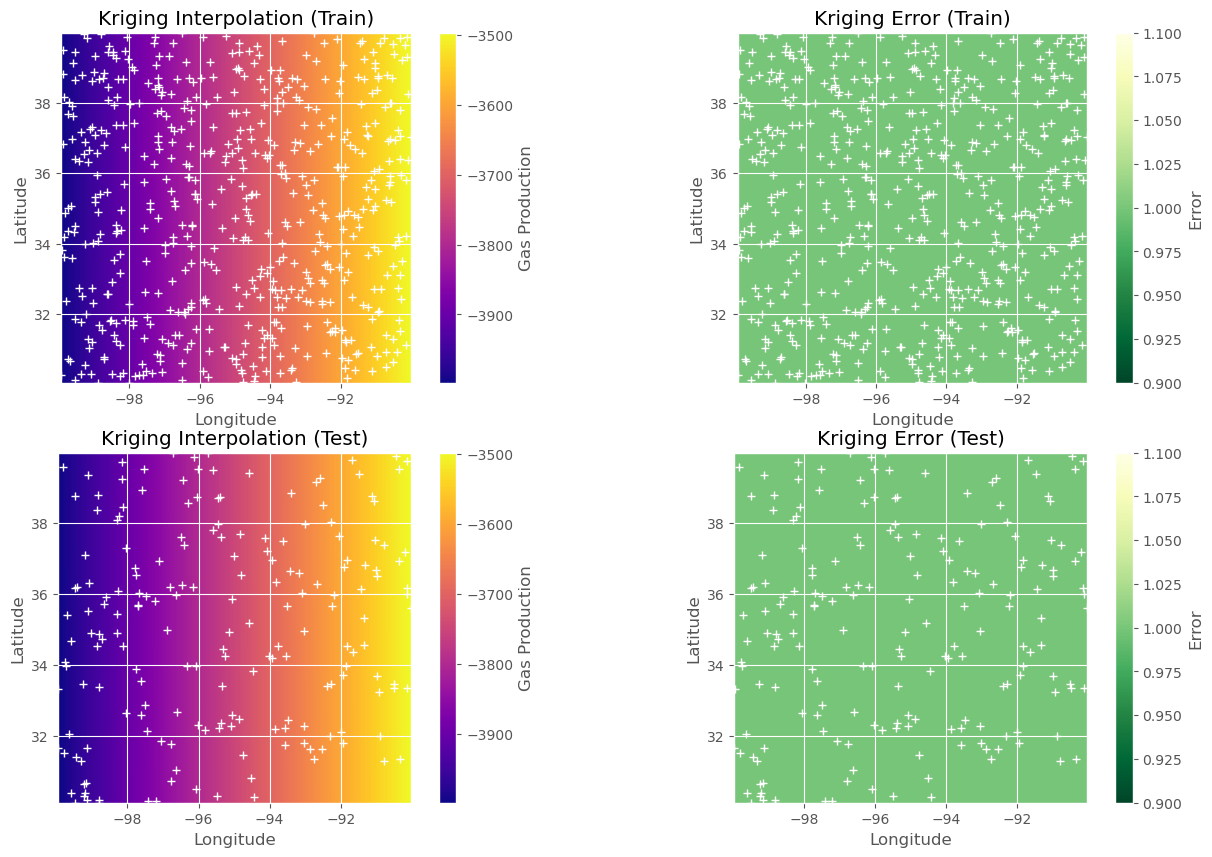

In [11]:
reg = LinearRegression()
reg.fit(xy_gasprod_train, v_gasprod_train)

def trend(x,y):
    return reg.predict(np.column_stack((x, y)))

detrended_gas = v_gasprod_train - trend(x_train, y_train)

gridx_train, gridy_train = np.meshgrid(
    np.linspace(x_train.min(), x_train.max(), 100),
    np.linspace(y_train.min(), y_train.max(), 100))
gridx_test, gridy_test = np.meshgrid(
    np.linspace(x_test.min(), x_test.max(), 100),
    np.linspace(y_test.min(), y_test.max(), 100))

model = Gaussian(
    dim=2, # 2d-array
    var=1,
    len_scale=1)

# model = Spherical(dim=2, var=0.1, len_scale=2)
# model = Exponential(dim=2, var=0.1, len_scale=2)
# model = Power(dim=2, var=0.1, len_scale=2)

krig_trend = krige.Detrended(
    model=model, 
    cond_pos=xy_gasprod_train, 
    cond_val=detrended_gas, 
    trend=trend)

z_train, s2_train = krig_trend((gridx_train.flatten(), gridy_train.flatten()))
z_test, s2_test = krig_trend((gridx_test.flatten(), gridy_test.flatten()))

z_train = z_train.reshape(100, 100)
s2_train = s2_train.reshape(100, 100)
z_test = z_test.reshape(100, 100)
s2_test = s2_test.reshape(100, 100)

z_test_pt, s2_test_pt = krig_trend((x_test, y_test))
pred = z_test_pt

rmse = np.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

print('\n------------\n')
print("RMSE:", round(rmse, 3))
print("MAE:", round(mae, 3))
print("R2:", round(r2, 3))
print('\n------------\n')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

im1 = ax1.imshow(z_train, cmap='plasma', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax1.set_title('Kriging Interpolation (Train)')
ax1.plot(x_train, y_train, 'w+')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.colorbar(im1, ax=ax1, label='Gas Production')

im2 = ax2.imshow(s2_train, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax2.set_title('Kriging Error (Train)')
ax2.plot(x_train, y_train, 'w+')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(im2, ax=ax2, label='Error')

im3 = ax3.imshow(z_test, cmap='plasma', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax3.set_title('Kriging Interpolation (Test)')
ax3.plot(x_test, y_test, 'w+')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
plt.colorbar(im3, ax=ax3, label='Gas Production')

im4 = ax4.imshow(s2_test, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax4.set_title('Kriging Error (Test)')
ax4.plot(x_test, y_test, 'w+')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
plt.colorbar(im4, ax=ax4, label='Error')

plt.show()
plt.close()

#### Method: Krige_Detrended GSTools Function - Hyperparameter Tuning


Best Parameters:
Variance: 1.0
Length Scale: 1.0
Best RMSE: 50.66126880456034

------------

RMSE: 50.661
MAE: 40.403
R2: 0.904

------------



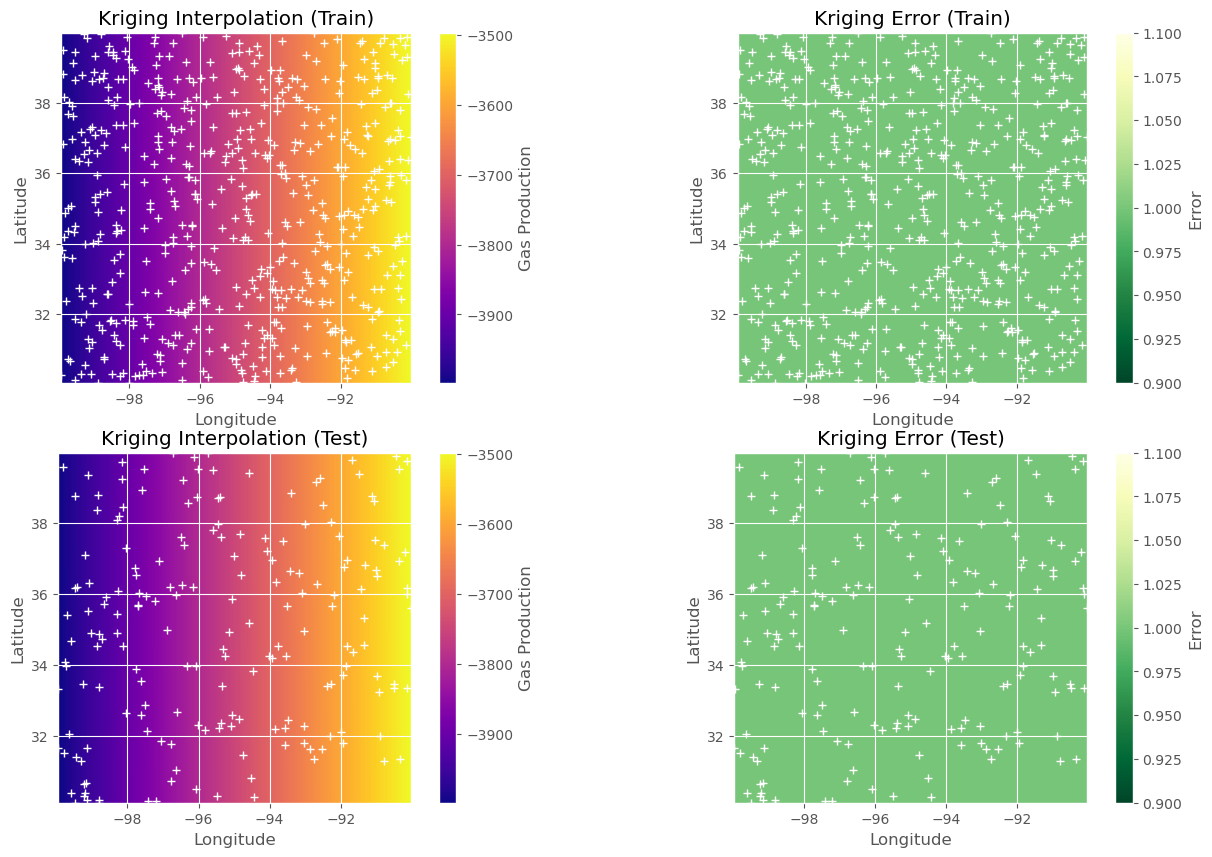

In [12]:
var_range = np.linspace(1, 100, 10)  # Variance range
len_scale_range = np.linspace(1, 50, 10)  # Length scale range

reg = LinearRegression().fit(xy_gasprod_train, v_gasprod_train)
trend_train = reg.predict(xy_gasprod_train)
detrended_gasprod_train = v_gasprod_train - trend_train

best_rmse = float('inf')
best_params = None

for var in var_range:
    for len_scale in len_scale_range:
        model = Gaussian(dim=2, var=var, len_scale=len_scale)
        krig_trend = krige.Detrended(
            model=model,
            cond_pos=xy_gasprod_train,
            cond_val=detrended_gasprod_train,
            trend=lambda x, y: reg.predict(np.column_stack((x, y))))
        
        pred_krige, error_krige = krig_trend((x_test, y_test))
        rmse = np.sqrt(mean_squared_error(v_gasprod_test, pred_krige))        
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = {'var': var, 'len_scale': len_scale}

print("\nBest Parameters:")
print(f"Variance: {best_params['var']}")
print(f"Length Scale: {best_params['len_scale']}")
print(f"Best RMSE: {best_rmse}")

best_model = Gaussian(dim=2, var=best_params['var'], len_scale=best_params['len_scale'])
final_krig_trend = krige.Detrended(
    model=best_model,
    cond_pos=xy_gasprod_train,
    cond_val=detrended_gasprod_train,
    trend=lambda x, y: reg.predict(np.column_stack((x, y))))

z_train, s2_train = final_krig_trend((gridx_train.flatten(), gridy_train.flatten()))
z_test, s2_test = final_krig_trend((gridx_test.flatten(), gridy_test.flatten()))

z_train = z_train.reshape(100, 100)
s2_train = s2_train.reshape(100, 100)
z_test = z_test.reshape(100, 100)
s2_test = s2_test.reshape(100, 100)

z_test_pt, s2_test_pt = final_krig_trend((x_test, y_test))
pred = z_test_pt

rmse = np.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

print('\n------------\n')
print("RMSE:", round(rmse, 3))
print("MAE:", round(mae, 3))
print("R2:", round(r2, 3))
print('\n------------\n')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

im1 = ax1.imshow(z_train, cmap='plasma', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax1.set_title('Kriging Interpolation (Train)')
ax1.plot(x_train, y_train, 'w+')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.colorbar(im1, ax=ax1, label='Gas Production')

im2 = ax2.imshow(s2_train, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax2.set_title('Kriging Error (Train)')
ax2.plot(x_train, y_train, 'w+')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(im2, ax=ax2, label='Error')

im3 = ax3.imshow(z_test, cmap='plasma', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax3.set_title('Kriging Interpolation (Test)')
ax3.plot(x_test, y_test, 'w+')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
plt.colorbar(im3, ax=ax3, label='Gas Production')

im4 = ax4.imshow(s2_test, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax4.set_title('Kriging Error (Test)')
ax4.plot(x_test, y_test, 'w+')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
plt.colorbar(im4, ax=ax4, label='Error')

plt.show()
plt.close()

### Kriging3D

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Using 'linear' Variogram Model
Slope: 0.41321585319082
Nugget: 23825.553520924335 



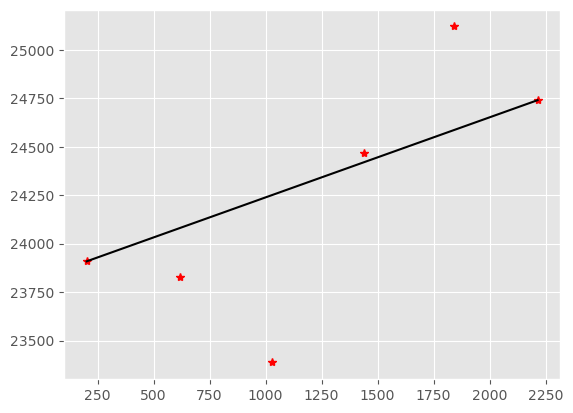

Calculating statistics on variogram model fit...
Q1 = 0.022578155716222206
Q2 = 1.0034607691737416
cR = 24366.66599102613 

Executing Ordinary Kriging...

Executing Ordinary Kriging...

Executing Ordinary Kriging...


------------

RMSE: 163.707
MAE: 139.8
R2: -0.006

------------



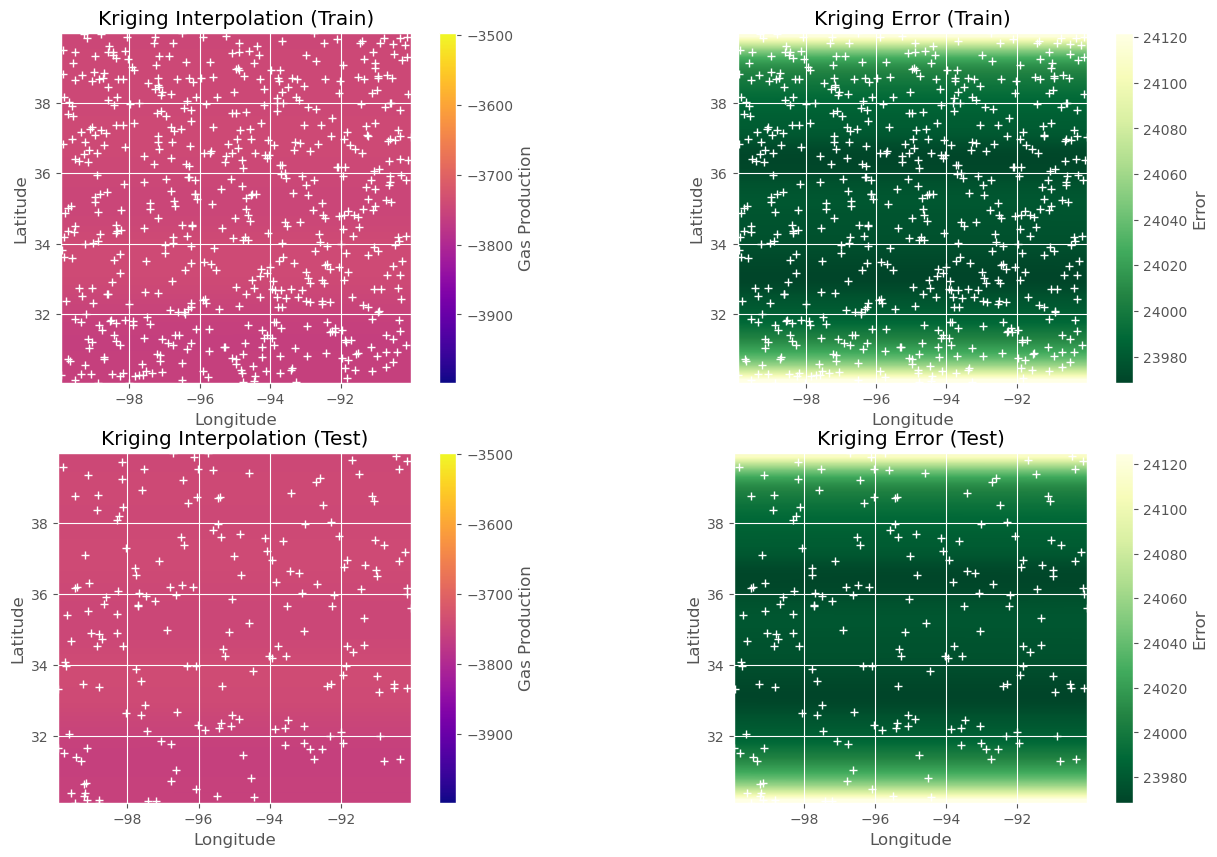

In [13]:
gridx_train = np.linspace(x_train.min(), x_train.max(), 50)
gridy_train = np.linspace(y_train.min(), y_train.max(), 50)
gridh_train = np.linspace(h_train.min(), h_train.max(), 50)

gridx_test = np.linspace(x_test.min(), x_test.max(), 50)
gridy_test = np.linspace(y_test.min(), y_test.max(), 50)
gridh_test = np.linspace(h_test.min(), h_test.max(), 50)

ok3d = OrdinaryKriging3D(
    x_train,
    y_train,
    h_train,
    v_gasprod_train,
    variogram_model='linear',
    verbose=True,
    enable_plotting=True )

z_train3d, s2_train3d = ok3d.execute("grid", gridx_train, gridy_train, gridh_train)
z_test3d, s2_test3d = ok3d.execute('grid', gridx_test, gridy_test, gridh_test)
pred, error = ok3d.execute('points', x_test, y_test, h_test)

rmse = np.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

print('\n------------\n')
print("RMSE:", round(rmse,3))
print("MAE:", round(mae,3))
print("R2:", round(r2,3))
print('\n------------\n')

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(16,10))

im1 = ax1.imshow(z_train3d[:,:,0], cmap='plasma', interpolation='bilinear', vmin=z_train.min(), vmax=z_train.max(),
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax1.set_title('Kriging Interpolation (Train)')
ax1.plot(x_train, y_train, 'w+')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.colorbar(im1, ax=ax1, label='Gas Production')

im2 = ax2.imshow(s2_train3d[:,:,0], cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax2.set_title('Kriging Error (Train)')
ax2.plot(x_train, y_train, 'w+')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(im2, ax=ax2, label='Error')

im3 = ax3.imshow(z_test3d[:,:,0], cmap='plasma', interpolation='bilinear', vmin=z_test.min(), vmax=z_test.max(),
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax3.set_title('Kriging Interpolation (Test)')
ax3.plot(x_test, y_test, 'w+')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
plt.colorbar(im3, ax=ax3, label='Gas Production')

im4 = ax4.imshow(s2_test3d[:,:,0], cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax4.set_title('Kriging Error (Test)')
ax4.plot(x_test, y_test, 'w+')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
plt.colorbar(im4, ax=ax4, label='Error')

plt.show()
plt.close()

In [14]:
After 90 minutes, the code completed running and i got the error:
```
---------------------------------------------------------------------------
LinAlgError                               Traceback (most recent call last)
Cell In[14], line 1
----> 1 ok3d = OrdinaryKriging3D(
      2     x_train,
      3     y_train,
      4     h_train,
      5     v_train,
      6     variogram_model='linear',
      7     verbose=True,
      8     enable_plotting=True )
     10 z_train3d, s2_train3d = ok3d.execute("grid", gridx_train, gridy_train, gridh_train)
     11 pred, error = ok3d.execute('points', x_test, y_test, h_test)

File /opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/pykrige/ok3d.py:352, in OrdinaryKriging3D.__init__(self, x, y, z, val, variogram_model, variogram_parameters, variogram_function, nlags, weight, anisotropy_scaling_y, anisotropy_scaling_z, anisotropy_angle_x, anisotropy_angle_y, anisotropy_angle_z, verbose, enable_plotting, exact_values, pseudo_inv, pseudo_inv_type)
    350 if self.verbose:
    351     print("Calculating statistics on variogram model fit...")
--> 352 self.delta, self.sigma, self.epsilon = _find_statistics(
    353     np.vstack((self.X_ADJUSTED, self.Y_ADJUSTED, self.Z_ADJUSTED)).T,
    354     self.VALUES,
    355     self.variogram_function,
    356     self.variogram_model_parameters,
    357     "euclidean",
    358     self.pseudo_inv,
    359 )
    360 self.Q1 = core.calcQ1(self.epsilon)
    361 self.Q2 = core.calcQ2(self.epsilon)

File /opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/pykrige/core.py:807, in _find_statistics(X, y, variogram_function, variogram_model_parameters, coordinates_type, pseudo_inv)
    804     continue
    806 else:
--> 807     k, ss = _krige(
    808         X[:i, :],
    809         y[:i],
    810         X[i, :],
    811         variogram_function,
    812         variogram_model_parameters,
    813         coordinates_type,
    814         pseudo_inv,
    815     )
    817     # if the estimation error is zero, it's probably because
    818     # the evaluation point X[i, :] is really close to one of the
    819     # kriging system points in X[:i, :]...
    820     # in the case of zero estimation error, the results are not stored
    821     if np.absolute(ss) < eps:

File /opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/pykrige/core.py:750, in _krige(X, y, coords, variogram_function, variogram_model_parameters, coordinates_type, pseudo_inv)
    748     res = np.linalg.lstsq(a, b, rcond=None)[0]
    749 else:
--> 750     res = np.linalg.solve(a, b)
    751 zinterp = np.sum(res[:n, 0] * y)
    752 sigmasq = np.sum(res[:, 0] * -b[:, 0])

File <__array_function__ internals>:180, in solve(*args, **kwargs)

File /opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/numpy/linalg/linalg.py:393, in solve(a, b)
    391 signature = 'DD->D' if isComplexType(t) else 'dd->d'
    392 extobj = get_linalg_error_extobj(_raise_linalgerror_singular)
--> 393 r = gufunc(a, b, signature=signature, extobj=extobj)
    395 return wrap(r.astype(result_t, copy=False))

File /opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/numpy/linalg/linalg.py:88, in _raise_linalgerror_singular(err, flag)
     87 def _raise_linalgerror_singular(err, flag):
---> 88     raise LinAlgError("Singular matrix")

LinAlgError: Singular matrix

SyntaxError: invalid syntax (3351773747.py, line 1)

### Plotting 3D Kriging Better

#### Matplotlib - Axes at Different Depth

In [ ]:
print(pd.DataFrame(h_train).describe(),'\n')
depth_slices = [510, 1159.75, 1736.5, 2376.75, 2998] # from h_train.describe()

slice_index = [np.abs(gridh_train - depth).argmin() for depth in depth_slices]

fig, axes = plt.subplots(1, len(slice_index), figsize=(18, 3))
for i, idx in enumerate(slice_index):
    im = axes[i].imshow(z_train3d[:, :, idx], cmap='plasma', origin='lower',
                        extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()))
    axes[i].set_title(f'Depth Slice at {gridh_train[idx]:.2f}')
    axes[i].set_xlabel('Longitude')
    axes[i].set_ylabel('Latitude')
    plt.colorbar(im, ax=axes[i], label='Gas Production')

plt.tight_layout()
plt.show()

#### Plotly 3D

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Isosurface(
    x=gridx_train.flatten(),
    y=gridy_train.flatten(),
    z=gridh_train.flatten(),
    value=z_train3d.flatten(),
    isomin=np.min(z_train3d),
    isomax=np.max(z_train3d),
    surface_count=10,  # Number of isosurfaces
    colorbar=dict(title='Gas Production'),
    colorscale='Plasma' ))

fig.update_layout(scene=dict(
    xaxis_title='Longitude',
    yaxis_title='Latitude',
    zaxis_title='Depth' ))

fig.show()

## Spatially Uncorrelated Data

### Inspect Data

In [ ]:
df = df_nocorr.copy()
print(df.info())
df.head()

### Data Overview Plot

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,5))
corr_plot = ax.scatter(np.array(df['Surface_Longitude']), np.array(df['Surface_Latitude']), 
                       s=50, c=np.array(df['GasProd']).flatten(), cmap='plasma', alpha=0.7)
plt.colorbar(corr_plot).set_label('Gas Production (Barrels)')
plt.title('Flattened Overview of Correlated Gas Production')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

### Coordinates, Values, and Grid Setup

In [ ]:
train, test = train_test_split(df, test_size=0.25, random_state=42)

xy_gasprod_train = np.array(train[['Surface_Longitude','Surface_Latitude']].values)
v_gasprod_train = np.array(train['GasProd'].values)
x_train = xy_gasprod_train[:,0]
y_train = xy_gasprod_train[:,1]
h_train = np.array(train['True_vertical_depth'].values)

xy_gasprod_test = np.array(test[['Surface_Longitude','Surface_Latitude']].values)
v_gasprod_test = np.array(test['GasProd'].values)
x_test = xy_gasprod_test[:,0]
y_test = xy_gasprod_test[:,1]
h_test = np.array(test['True_vertical_depth'].values)

gridx_train = np.linspace(x_train.min(), x_train.max(), 100)
gridy_train = np.linspace(y_train.min(), y_train.max(), 100)
gridh_train = np.linspace(h_train.min(), h_train.max(), 100)

gridx_test = np.linspace(x_test.min(), x_test.max(), 100)
gridy_test = np.linspace(y_test.min(), y_test.max(), 100)
gridh_test = np.linspace(h_test.min(), h_test.max(), 100)

actual = v_gasprod_test

### Basic Model - Kriging

In [ ]:
ok = OrdinaryKriging(
    x_train,
    y_train,
    v_gasprod_train,
    variogram_model='linear',
    verbose=False,
    enable_plotting=True )

z_train, s2_train = ok.execute("grid", gridx_train, gridy_train)
z_test, s2_test = ok.execute('grid', gridx_test, gridy_test)
pred, error = ok.execute('points', x_test, y_test)

rmse = np.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

print('\n------------\n')
print("RMSE:", round(rmse,3))
print("MAE:", round(mae,3))
print("R2:", round(r2,3))
print('\n------------\n')

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(16,10))

im1 = ax1.imshow(z_train, cmap='plasma', interpolation='bilinear', vmin=z_train.min(), vmax=z_train.max(),
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax1.set_title('Kriging Interpolation (Train)')
ax1.plot(x_train, y_train, 'w+')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.colorbar(im1, ax=ax1, label='Gas Production')

im2 = ax2.imshow(s2_train, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax2.set_title('Kriging Error (Train)')
ax2.plot(x_train, y_train, 'w+')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(im2, ax=ax2, label='Error')

im3 = ax3.imshow(z_test, cmap='plasma', interpolation='bilinear', vmin=z_test.min(), vmax=z_test.max(),
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax3.set_title('Kriging Interpolation (Test)')
ax3.plot(x_test, y_test, 'w+')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
plt.colorbar(im3, ax=ax3, label='Gas Production')

im4 = ax4.imshow(s2_test, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax4.set_title('Kriging Error (Test)')
ax4.plot(x_test, y_test, 'w+')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
plt.colorbar(im4, ax=ax4, label='Error')

plt.show()
plt.close()

### Kriging Hyperparameter Tuning

In [ ]:
param_grid = {
    'method': ['ordinary'], # 'universal'],
    'variogram_model': ['linear','power','gaussian','spherical']
    # 'nlags': [4,6,8],
    # 'weight': [True,False]
}

estimator = GridSearchCV (
    Krige(), 
    param_grid, 
    cv=5, 
    scoring='neg_root_mean_squared_error',
    verbose=True, 
    return_train_score=True )

estimator.fit(X=xy_gasprod_train, y=v_gasprod_train)

if estimator.best_score_:
    print("best_RMSE = {:.3f}".format(estimator.best_score_))
    print("best_params = ", estimator.best_params_)

best_model = estimator.best_estimator_
best_model = best_model.model

z_train, s2_train = best_model.execute('grid', gridx_train, gridy_train)
z_test, s2_test = best_model.execute('grid', gridx_test, gridy_test)
pred, error = best_model.execute('points', x_test, y_test)

rmse = np.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

print('\n------------\n')
print("RMSE:", round(rmse,3))
print("MAE:", round(mae,3))
print("R2:", round(r2,3))
print('\n------------\n')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

im1 = ax1.imshow(z_train, cmap='plasma', interpolation='bilinear', vmin=z_train.min(), vmax=z_train.max(),
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax1.set_title('Kriging Interpolation (Train)')
ax1.plot(x_train, y_train, 'w+')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.colorbar(im1, ax=ax1, label='Gas Production')

im2 = ax2.imshow(s2_train, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax2.set_title('Kriging Error (Train)')
ax2.plot(x_train, y_train, 'w+')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(im2, ax=ax2, label='Error')

im3 = ax3.imshow(z_test, cmap='plasma', interpolation='bilinear', vmin=z_test.min(), vmax=z_test.max(),
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax3.set_title('Kriging Interpolation (Test)')
ax3.plot(x_test, y_test, 'w+')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
plt.colorbar(im3, ax=ax3, label='Gas Production')

im4 = ax4.imshow(s2_test, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax4.set_title('Kriging Error (Test)')
ax4.plot(x_test, y_test, 'w+')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
plt.colorbar(im4, ax=ax4, label='Error')

plt.show()
plt.close()

### Stationarity vs Isotropy vs Anisotropy

#### Stationarity
Stationarity assumes that statistical properties like mean and variance are constant across the spatial domain. OrdinaryKriging assumes stationarity.

In [ ]:
ok = OrdinaryKriging(
    x_train, y_train, v_gasprod_train,
    variogram_model='spherical',
    verbose=True,
    enable_plotting=True )

z_train, s2_train = ok.execute('grid', gridx_train, gridy_train)
z_test, s2_test = ok.execute('grid', gridx_test, gridy_test)
pred, error = ok.execute('points', x_test, y_test)

rmse = np.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

print('\n------------\n')
print("RMSE:", round(rmse,3))
print("MAE:", round(mae,3))
print("R2:", round(r2,3))
print('\n------------\n')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

im1 = ax1.imshow(z_train, cmap='plasma', interpolation='bilinear', vmin=z_train.min(), vmax=z_train.max(),
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax1.set_title('Kriging Interpolation (Train)')
ax1.plot(x_train, y_train, 'w+')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.colorbar(im1, ax=ax1, label='Gas Production')

im2 = ax2.imshow(s2_train, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax2.set_title('Kriging Error (Train)')
ax2.plot(x_train, y_train, 'w+')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(im2, ax=ax2, label='Error')

im3 = ax3.imshow(z_test, cmap='plasma', interpolation='bilinear', vmin=z_test.min(), vmax=z_test.max(),
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax3.set_title('Kriging Interpolation (Test)')
ax3.plot(x_test, y_test, 'w+')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
plt.colorbar(im3, ax=ax3, label='Gas Production')

im4 = ax4.imshow(s2_test, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax4.set_title('Kriging Error (Test)')
ax4.plot(x_test, y_test, 'w+')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
plt.colorbar(im4, ax=ax4, label='Error')

plt.show()
plt.close()

#### Isotropy
Isotropy assumes that the spatial correlation is the same in all directions.

In [ ]:
variogram_parameters = {
    'range': 10,
    'nugget': 0,
    'sill': 0.5 }

ok = OrdinaryKriging(
    x_train, y_train, v_gasprod_train,
    variogram_model='spherical',
    variogram_parameters=variogram_parameters,
    verbose=True,
    enable_plotting=True )

z_train, s2_train = ok.execute('grid', gridx_train, gridy_train)
z_test, s2_test = ok.execute('grid', gridx_test, gridy_test)
pred, error = ok.execute('points', x_test, y_test)

rmse = np.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

print('\n------------\n')
print("RMSE:", round(rmse,3))
print("MAE:", round(mae,3))
print("R2:", round(r2,3))
print('\n------------\n')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

im1 = ax1.imshow(z_train, cmap='plasma', interpolation='bilinear', vmin=z_train.min(), vmax=z_train.max(),
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax1.set_title('Kriging Interpolation (Train)')
ax1.plot(x_train, y_train, 'w+')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.colorbar(im1, ax=ax1, label='Gas Production')

im2 = ax2.imshow(s2_train, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax2.set_title('Kriging Error (Train)')
ax2.plot(x_train, y_train, 'w+')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(im2, ax=ax2, label='Error')

im3 = ax3.imshow(z_test, cmap='plasma', interpolation='bilinear', vmin=z_test.min(), vmax=z_test.max(),
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax3.set_title('Kriging Interpolation (Test)')
ax3.plot(x_test, y_test, 'w+')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
plt.colorbar(im3, ax=ax3, label='Gas Production')

im4 = ax4.imshow(s2_test, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax4.set_title('Kriging Error (Test)')
ax4.plot(x_test, y_test, 'w+')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
plt.colorbar(im4, ax=ax4, label='Error')

plt.show()
plt.close()

#### Anisotropy
Anisotropy assumes that the spatial correlation varies with direction.

In [ ]:
anisotropy_scaling = 2.0
anisotropy_angle = 45.0

ok = OrdinaryKriging(
    x_train, y_train, v_gasprod_train,
    variogram_model='spherical',
    anisotropy_scaling=anisotropy_scaling,
    anisotropy_angle=anisotropy_angle,
    verbose=True,
    enable_plotting=True )

z_train, s2_train = ok.execute('grid', gridx_train, gridy_train)
z_test, s2_test = ok.execute('grid', gridx_test, gridy_test)
pred, error = ok.execute('points', x_test, y_test)

rmse = np.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

print('\n------------\n')
print("RMSE:", round(rmse,3))
print("MAE:", round(mae,3))
print("R2:", round(r2,3))
print('\n------------\n')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

im1 = ax1.imshow(z_train, cmap='plasma', interpolation='bilinear', vmin=z_train.min(), vmax=z_train.max(),
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax1.set_title('Kriging Interpolation (Train)')
ax1.plot(x_train, y_train, 'w+')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.colorbar(im1, ax=ax1, label='Gas Production')

im2 = ax2.imshow(s2_train, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax2.set_title('Kriging Error (Train)')
ax2.plot(x_train, y_train, 'w+')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(im2, ax=ax2, label='Error')

im3 = ax3.imshow(z_test, cmap='plasma', interpolation='bilinear', vmin=z_test.min(), vmax=z_test.max(),
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax3.set_title('Kriging Interpolation (Test)')
ax3.plot(x_test, y_test, 'w+')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
plt.colorbar(im3, ax=ax3, label='Gas Production')

im4 = ax4.imshow(s2_test, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax4.set_title('Kriging Error (Test)')
ax4.plot(x_test, y_test, 'w+')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
plt.colorbar(im4, ax=ax4, label='Error')

plt.show()
plt.close()

### Krige Detrend

#### Method: Subtracting Actual Values from Trend Values (found from Linear Regression)

In [ ]:
reg = LinearRegression().fit(xy_gasprod_train, v_gasprod_train)
trend_train = reg.predict(xy_gasprod_train)
detrended_gasprod_train = v_gasprod_train - trend_train

ok = OrdinaryKriging(
    x_train,
    y_train,
    detrended_gasprod_train,
    variogram_model='linear',
    verbose=False,
    enable_plotting=True )

z_train, s2_train = ok.execute("grid", gridx_train, gridy_train)
z_test, s2_test = ok.execute('grid', gridx_test, gridy_test)
pred, error = ok.execute('points', x_test, y_test)
pred += (reg.predict(xy_gasprod_test))

rmse = np.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

print('\n------------\n')
print("RMSE:", round(rmse,3))
print("MAE:", round(mae,3))
print("R2:", round(r2,3))
print('\n------------\n')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

im1 = ax1.imshow(z_train, cmap='plasma', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax1.set_title('Kriging Interpolation (Train)')
ax1.plot(x_train, y_train, 'w+')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.colorbar(im1, ax=ax1, label='Gas Production')

im2 = ax2.imshow(s2_train, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax2.set_title('Kriging Error (Train)')
ax2.plot(x_train, y_train, 'w+')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(im2, ax=ax2, label='Error')

im3 = ax3.imshow(z_test, cmap='plasma', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax3.set_title('Kriging Interpolation (Test)')
ax3.plot(x_test, y_test, 'w+')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
plt.colorbar(im3, ax=ax3, label='Gas Production')

im4 = ax4.imshow(s2_test, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax4.set_title('Kriging Error (Test)')
ax4.plot(x_test, y_test, 'w+')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
plt.colorbar(im4, ax=ax4, label='Error')

plt.show()
plt.close()

#### Method: Krige_Detrended GSTools Function

In [ ]:
reg = LinearRegression()
reg.fit(xy_gasprod_train, v_gasprod_train)

def trend(x,y):
    return reg.predict(np.column_stack((x, y)))

detrended_gas = v_gasprod_train - trend(x_train, y_train)

gridx_train, gridy_train = np.meshgrid(
    np.linspace(x_train.min(), x_train.max(), 100),
    np.linspace(y_train.min(), y_train.max(), 100))
gridx_test, gridy_test = np.meshgrid(
    np.linspace(x_test.min(), x_test.max(), 100),
    np.linspace(y_test.min(), y_test.max(), 100))

model = Gaussian(
    dim=2, # 2d-array
    var=1,
    len_scale=1)

# model = Spherical(dim=2, var=0.1, len_scale=2)
# model = Exponential(dim=2, var=0.1, len_scale=2)
# model = Power(dim=2, var=0.1, len_scale=2)

krig_trend = krige.Detrended(
    model=model, 
    cond_pos=xy_gasprod_train, 
    cond_val=detrended_gas, 
    trend=trend)

z_train, s2_train = krig_trend((gridx_train.flatten(), gridy_train.flatten()))
z_test, s2_test = krig_trend((gridx_test.flatten(), gridy_test.flatten()))

z_train = z_train.reshape(100, 100)
s2_train = s2_train.reshape(100, 100)
z_test = z_test.reshape(100, 100)
s2_test = s2_test.reshape(100, 100)

z_test_pt, s2_test_pt = krig_trend((x_test, y_test))
pred = z_test_pt

rmse = np.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

print('\n------------\n')
print("RMSE:", round(rmse, 3))
print("MAE:", round(mae, 3))
print("R2:", round(r2, 3))
print('\n------------\n')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

im1 = ax1.imshow(z_train, cmap='plasma', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax1.set_title('Kriging Interpolation (Train)')
ax1.plot(x_train, y_train, 'w+')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.colorbar(im1, ax=ax1, label='Gas Production')

im2 = ax2.imshow(s2_train, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax2.set_title('Kriging Error (Train)')
ax2.plot(x_train, y_train, 'w+')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(im2, ax=ax2, label='Error')

im3 = ax3.imshow(z_test, cmap='plasma', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax3.set_title('Kriging Interpolation (Test)')
ax3.plot(x_test, y_test, 'w+')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
plt.colorbar(im3, ax=ax3, label='Gas Production')

im4 = ax4.imshow(s2_test, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax4.set_title('Kriging Error (Test)')
ax4.plot(x_test, y_test, 'w+')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
plt.colorbar(im4, ax=ax4, label='Error')

plt.show()
plt.close()

#### Method: Krige_Detrended GSTools Function - Hyperparameter Tuning

In [ ]:
var_range = np.linspace(1, 100, 10)  # Variance range
len_scale_range = np.linspace(1, 50, 10)  # Length scale range

reg = LinearRegression().fit(xy_gasprod_train, v_gasprod_train)
trend_train = reg.predict(xy_gasprod_train)
detrended_gasprod_train = v_gasprod_train - trend_train

best_rmse = float('inf')
best_params = None

for var in var_range:
    for len_scale in len_scale_range:
        model = Gaussian(dim=2, var=var, len_scale=len_scale)
        krig_trend = krige.Detrended(
            model=model,
            cond_pos=xy_gasprod_train,
            cond_val=detrended_gasprod_train,
            trend=lambda x, y: reg.predict(np.column_stack((x, y))))
        
        pred_krige, error_krige = krig_trend((x_test, y_test))
        rmse = np.sqrt(mean_squared_error(v_gasprod_test, pred_krige))        
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = {'var': var, 'len_scale': len_scale}

print("\nBest Parameters:")
print(f"Variance: {best_params['var']}")
print(f"Length Scale: {best_params['len_scale']}")
print(f"Best RMSE: {best_rmse}")

best_model = Gaussian(dim=2, var=best_params['var'], len_scale=best_params['len_scale'])
final_krig_trend = krige.Detrended(
    model=best_model,
    cond_pos=xy_gasprod_train,
    cond_val=detrended_gasprod_train,
    trend=lambda x, y: reg.predict(np.column_stack((x, y))))

z_train, s2_train = final_krig_trend((gridx_train.flatten(), gridy_train.flatten()))
z_test, s2_test = final_krig_trend((gridx_test.flatten(), gridy_test.flatten()))

z_train = z_train.reshape(100, 100)
s2_train = s2_train.reshape(100, 100)
z_test = z_test.reshape(100, 100)
s2_test = s2_test.reshape(100, 100)

z_test_pt, s2_test_pt = final_krig_trend((x_test, y_test))
pred = z_test_pt

rmse = np.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

print('\n------------\n')
print("RMSE:", round(rmse, 3))
print("MAE:", round(mae, 3))
print("R2:", round(r2, 3))
print('\n------------\n')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

im1 = ax1.imshow(z_train, cmap='plasma', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax1.set_title('Kriging Interpolation (Train)')
ax1.plot(x_train, y_train, 'w+')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.colorbar(im1, ax=ax1, label='Gas Production')

im2 = ax2.imshow(s2_train, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax2.set_title('Kriging Error (Train)')
ax2.plot(x_train, y_train, 'w+')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(im2, ax=ax2, label='Error')

im3 = ax3.imshow(z_test, cmap='plasma', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax3.set_title('Kriging Interpolation (Test)')
ax3.plot(x_test, y_test, 'w+')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
plt.colorbar(im3, ax=ax3, label='Gas Production')

im4 = ax4.imshow(s2_test, cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax4.set_title('Kriging Error (Test)')
ax4.plot(x_test, y_test, 'w+')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
plt.colorbar(im4, ax=ax4, label='Error')

plt.show()
plt.close()

### Kriging3D

In [ ]:
gridx_train = np.linspace(x_train.min(), x_train.max(), 50)
gridy_train = np.linspace(y_train.min(), y_train.max(), 50)
gridh_train = np.linspace(h_train.min(), h_train.max(), 50)

gridx_test = np.linspace(x_test.min(), x_test.max(), 50)
gridy_test = np.linspace(y_test.min(), y_test.max(), 50)
gridh_test = np.linspace(h_test.min(), h_test.max(), 50)

ok3d = OrdinaryKriging3D(
    x_train,
    y_train,
    h_train,
    v_gasprod_train,
    variogram_model='linear',
    verbose=True,
    enable_plotting=True )

z_train, s2_train = ok3d.execute("grid", gridx_train, gridy_train, gridh_train)
z_test, s2_test = ok3d.execute('grid', gridx_test, gridy_test, gridh_test)
pred, error = ok3d.execute('points', x_test, y_test, h_test)

rmse = np.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

print('\n------------\n')
print("RMSE:", round(rmse,3))
print("MAE:", round(mae,3))
print("R2:", round(r2,3))
print('\n------------\n')

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(16,10))

im1 = ax1.imshow(z_train[:,:,0], cmap='plasma', interpolation='bilinear', vmin=z_train.min(), vmax=z_train.max(),
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax1.set_title('Kriging Interpolation (Train)')
ax1.plot(x_train, y_train, 'w+')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.colorbar(im1, ax=ax1, label='Gas Production')

im2 = ax2.imshow(s2_train[:,:,0], cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
ax2.set_title('Kriging Error (Train)')
ax2.plot(x_train, y_train, 'w+')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(im2, ax=ax2, label='Error')

im3 = ax3.imshow(z_test[:,:,0], cmap='plasma', interpolation='bilinear', vmin=z_test.min(), vmax=z_test.max(),
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax3.set_title('Kriging Interpolation (Test)')
ax3.plot(x_test, y_test, 'w+')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
plt.colorbar(im3, ax=ax3, label='Gas Production')

im4 = ax4.imshow(s2_test[:,:,0], cmap='YlGn_r', interpolation='bilinear',
                 extent=(gridx_test.min(), gridx_test.max(), gridy_test.min(), gridy_test.max()), origin='lower')
ax4.set_title('Kriging Error (Test)')
ax4.plot(x_test, y_test, 'w+')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
plt.colorbar(im4, ax=ax4, label='Error')

plt.show()
plt.close()

### Plotting 3D Kriging Better

#### Matplotlib - Axes at Different Depth

In [ ]:
print(pd.DataFrame(h_train).describe(),'\n')
depth_slices = [510, 1159.75, 1736.5, 2376.75, 2998] # from h_train.describe()

slice_index = [np.abs(gridh_train - depth).argmin() for depth in depth_slices]

fig, axes = plt.subplots(1, len(slice_index), figsize=(18, 3))
for i, idx in enumerate(slice_index):
    im = axes[i].imshow(z_train3d[:, :, idx], cmap='plasma', origin='lower',
                        extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()))
    axes[i].set_title(f'Depth Slice at {gridh_train[idx]:.2f}')
    axes[i].set_xlabel('Longitude')
    axes[i].set_ylabel('Latitude')
    plt.colorbar(im, ax=axes[i], label='Gas Production')

plt.tight_layout()
plt.show()

#### Plotly 3D

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Isosurface(
    x=gridx_train.flatten(),
    y=gridy_train.flatten(),
    z=gridh_train.flatten(),
    value=z_train3d.flatten(),
    isomin=np.min(z_train3d),
    isomax=np.max(z_train3d),
    surface_count=10,  # Number of isosurfaces
    colorbar=dict(title='Gas Production'),
    colorscale='Plasma' ))

fig.update_layout(scene=dict(
    xaxis_title='Longitude',
    yaxis_title='Latitude',
    zaxis_title='Depth' ))

fig.show()

## Script

In [ ]:
try:
    print('Script executed successfully.')
except:
    print('FAILED')